# updated: 05/06/2020

### to do

#### testar polifit-3
#### para ajuste das manchas usar interporlate model/transit

In [1]:
__author__ = "Yuri Neto, Felipe Pinho, Beatriz Duque, Adriana Valio (Orientadora)"
__copyright__ = "..."
__credits__ = ["Universidade Presbiteriana Mackenzie, CRAAM"]
__license__ = ""
__version__ = ""
__maintainer__ = ""
__email__ = "starsandexoplanets@gmail.com"
__status__ = "Production"

In [2]:
%matplotlib nbagg
#%matplotlib inline

import lightkurve as lk
from lightkurve import search_lightcurve

import numpy
import matplotlib as mpl
from matplotlib import pyplot
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate
from scipy import ndimage
import scipy.signal as sps
from scipy.optimize import minimize
from PyAstronomy.pyasl import binningx0dt
import collections
import glob
from astropy.io import fits
import pandas as pd
import matplotlib.patches as mpatches
import lmfit
from lmfit import Model
import emcee
import corner
from IPython.display import display, Math
from estrela_nv1 import estrela #estrela e eclipse:: extensões de programas auxiliares que realizam o cálculo da curva de luz.
from eclipse_nv1 import Eclipse
from verify import Validar, calSemiEixo

import requests
from logging import Handler, Formatter
import logging
import datetime
from pytz import timezone

import timeit

from IPython.display import display, Math

In [3]:
'''##CODIGO PARA ENVIAR MSG PARA O TELEGRAM!!
##funcao criada para que a mensagem seja enviada para o TELEGRAM quando os OUTPUTS do programa forem coletados.
TELEGRAM_TOKEN = '985880683:AAG216chgk6WGIsrTKWREERbUAv3lpiKf0c'
TELEGRAM_CHAT_ID = '772206467'

class RequestsHandler(Handler):
    def emit(self, record):
        log_entry = self.format(record)
        payload = {
            'chat_id': TELEGRAM_CHAT_ID,
            'text': log_entry,
            'parse_mode': 'HTML'
        }
        return requests.post("https://api.telegram.org/bot{token}/sendMessage".format(token=TELEGRAM_TOKEN),
                             data=payload).content

class LogstashFormatter(Formatter):
    def __init__(self):
        super(LogstashFormatter, self).__init__()

    def format(self, record):
        sphr = timezone('America/Sao_Paulo')
        t = datetime.datetime.now(tz = sphr).strftime('%d-%m-%Y %H:%M:%S')

        return "<i>{datetime}</i><pre>\n{message}</pre>".format(message=record.msg, datetime=t)
    
logger = logging.getLogger('trymeApp')
logger.setLevel(logging.INFO)

handler = RequestsHandler()
formatter = LogstashFormatter()
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.setLevel(logging.INFO)
'''

'##CODIGO PARA ENVIAR MSG PARA O TELEGRAM!!\n##funcao criada para que a mensagem seja enviada para o TELEGRAM quando os OUTPUTS do programa forem coletados.\nTELEGRAM_TOKEN = \'985880683:AAG216chgk6WGIsrTKWREERbUAv3lpiKf0c\'\nTELEGRAM_CHAT_ID = \'772206467\'\n\nclass RequestsHandler(Handler):\n    def emit(self, record):\n        log_entry = self.format(record)\n        payload = {\n            \'chat_id\': TELEGRAM_CHAT_ID,\n            \'text\': log_entry,\n            \'parse_mode\': \'HTML\'\n        }\n        return requests.post("https://api.telegram.org/bot{token}/sendMessage".format(token=TELEGRAM_TOKEN),\n                             data=payload).content\n\nclass LogstashFormatter(Formatter):\n    def __init__(self):\n        super(LogstashFormatter, self).__init__()\n\n    def format(self, record):\n        sphr = timezone(\'America/Sao_Paulo\')\n        t = datetime.datetime.now(tz = sphr).strftime(\'%d-%m-%Y %H:%M:%S\')\n\n        return "<i>{datetime}</i><pre>\n{message}

In [7]:
def rd_data(star_name, cadence, plot, save_data):
    
    ''' 
    Funcao criada para acessar os dados de curva de luz de estrelas e extrair o tempo e fluxo. 
    
    lightkurve packeage:: utilizado para abrir as curvas de Luz do Kepler e
    também abrir curva de luz do TESS/ curvas de luz em geral
    Documentação:: https://docs.lightkurve.org/api/index.html documentação do uso do lightkurve
    
    parâmetro star_name :: nome da estrela 
    parâmetro cadence :: short ou long 
    outputs esperados:: time, flux 
    
    plot = 1 (plota a curva de luz, para não plotar basta digitar qualquer valor)
    save_data = 1 plota a curva de luz(para não plotar, basta digitar qualquer valor)
    '''
##--------------------------------------------------------------------------------------------------------------------------------------------------##
# utiiza-se o PDCSAP_FLUX porque será realizado a análise no trânsito.
    lc = search_lightcurve(star_name, cadence = cadence).download_all().PDCSAP_FLUX
    time = [] # time = array com os dados de tempo
    flux = [] # flux = array com os dados de fluxo
    flux_err = [] # flux_err = array com os dados de erro do fluxo
    time_temp = [] #_variavel temporaria
    flux_temp = []
    flux_err_temp = []
    for i in range(0, len(lc)-1):
        flux_temp.append(lc[i].flux)
        flux_err_temp.append(lc[i].flux_err)
        time_temp.append(lc[i].time)

    for i in range(0, len(lc)-1):   
        
# Limita os índices aos valores de tempo lidos
        flux_temp[i] = flux_temp[i][0:time_temp[i].size]
        flux_err_temp[i] = flux_err_temp[i][0:time_temp[i].size]
    
# Elimina todos os valores NaN (Not a Number) dos dados
        time_temp[i] = time_temp[i][~numpy.isnan(flux_err_temp[i])]
        flux_temp[i] = flux_temp[i][~numpy.isnan(flux_err_temp[i])]
        flux_err_temp[i] = flux_err_temp[i][~numpy.isnan(flux_err_temp[i])]
    
# Normaliza cada quarter
        flux_err_temp[i] = flux_err_temp[i]/ abs(numpy.median(flux_temp[i]))
        flux_temp[i] = flux_temp[i]/ abs(numpy.median(flux_temp[i]))

    for i in range(0, len(lc)-1):
        flux = numpy.append(flux, flux_temp[i])
        time = numpy.append(time, time_temp[i])
        flux_err = numpy.append(flux_err, flux_err_temp[i])
    
  #plot da curva de luz completa
    if plot == (1):
        plt.rcParams['figure.figsize'] = 10,4
        graf1, ax = plt.subplots()

        ax.set_xlabel('Time (BJD - 2454833)')
        ax.set_ylabel('Normalized Flux')

        ax.set_title("Light Curve - " + star_name)
        ax.set_xlim(min(time), max(time))
        ax.set_ylim(min(flux), max(flux))
    
        #ax.plot(time, flux, "k.", ms=2)
        
        ax.errorbar(time, flux, yerr = flux_err, fmt = '.k', capsize = 0,alpha = 0.5)
        
  #salva os dados em um arquivo .dat
    if save_data == 1:
        numpy.savetxt('%s_LC.dat'%star_name, numpy.c_[(time, flux, flux_err)])

    return time, flux, flux_err
#--------------------------------------------------#

def det_x0(time, flux, porb, plot):
    
    '''
    Função para obter o centro do primeiro transito. 
    porb é utilizado para criar uma curva de luz em fase é aplicado um smooth na curva de luz em fase.
    parâmetro time::
    parâmetro flux:: 
    parâmetro porb:: periodo orbital do planeta (per em dias)
    parâmetro plot:: 
    
    returns
    x0 = valor do centro do primeiro transito 
    nt = numero de transitos possiveis 
    plot = 1 (plota a curva de luz, para nao plotar basta digitar qualquer valor)
    '''
    
    phase = (time % porb)/ porb
    jj = numpy.argsort(phase)
    ff = phase[jj]

    smoothed_LC = scipy.ndimage.filters.uniform_filter(flux[jj], size = 100) # equivalente ao smooth do idl com edge_truncade
    smoothed_LC[0:200] = 1
    smoothed_LC[len(flux[jj])-200:len(flux[jj])] = 1
    x = phase[jj]
    y = 1 - smoothed_LC
    yh = 0.002

    kk = numpy.where(y >= yh)

    x1 = min(x[kk])
    x2 = max(x[kk])
    fa0 = (x1 + x2)/ 2 # valor central dos transitos em fase

    x0 = (numpy.fix(time[0] / porb) + fa0) * porb # tempo central do primeiro transito
    
    nt = numpy.fix(max(time - time[0])/ porb) + 1 # numero de transitos possiveis

    #plot da curva de luz completa
    if plot == 1:
    
        plt.rcParams['figure.figsize'] = 10,8
        graf2, ax = plt.subplots(2, 1, sharex = False, gridspec_kw = {'height_ratios': [1, 1]})
        graf2.subplots_adjust(hspace = 0.5)
    
        ax[0].set_ylim(0.9, 1.1)
        ax[0].set_title("Phased LC")
    
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Normalized Flux')

        ax[0].plot(phase, flux, "k.", ms = 2)
        ax[0].plot(phase[jj], smoothed_LC, "r.", ms = 2)        
    
        ax[1].set_ylim(0.9, 1.1)
        ax[1].set_title("x0 = tempo central do primeiro transito")
    
        ax[1].set_xlabel('Time (BJD - 2454833)')
        ax[1].set_ylabel('Normalized Flux')
    
        ax[1].set_xlim(min(time) - 2, min(time) + 2)
        ax[1].set_ylim(0.95, 1.01)
    
        ax[1].plot(time, flux, "k.", ms=2)

        plt.axvline(x = x0,linewidth = 2, color='r')
    
    return x0, nt
#--------------------------------------------------#
def limb(u1, u2, plot):
    '''
    Funcao que gera uma estrela sintetizada com 
    obscurecimento de limbo dado por 1-u1*(1-cos(mu))-u2*(1-cos(mu))^2), onde mu=angulo heliocentrico
    
    -- coeficiente de escurecimento de limbo --
    parâmetro u1 :: coeficiente linear 
    parâmetro u2 :: coeficiente do termo quadratico
    
    returns 
    parâmetro wl:: matriz com a intensidade da estrela
    se plot = 1, plota o perfil da estrela (para não plotar, basta digitar qualquer valor)

    '''
    #PERGUNTAR 
    if u1 == 999:
        u1 = 0.59
    if u2 == 999:
        u2 = 0.0
        
    n = 856 #tamanho da matriz 
    r = 373. #raio da estrela em pixel 
    mx = 240. #intensidade maxima da estrela em pixel 
    
    wl = numpy.zeros((n, n))
    x = numpy.arange(n/2-n, n-n/2, 1)
    
    for j in range (0, n):     
        z = numpy.sqrt(x**2 + (j - n/2.)**2)
        kk = numpy.where(z <= r)
        if kk[0].size > 0:
                m = numpy.cos(numpy.arcsin(z[kk]/r))
                wl[kk, j] = mx*(1 - u1*(1 - m) - u2*(1 - m)**2)
    
    data = wl[:,int(n/2)]
    smoothed = scipy.ndimage.filters.uniform_filter(data, size = 5)

    if plot == 1:
        plt.rcParams['figure.figsize']= 12, 5
        graf1,ax = plt.subplots()
        ax.plot(x,smoothed)
        ax.plot(x, wl[:, 428],'k')
        ax.set_title('limb')
        
    return wl, u1, u2
#--------------------------------------------------#
def get_param(r2, ap, a, rp):
    '''
    Funcao para obter parametros iniciais 
    parâmetro r2 ::raio do planeta em Rjup 
    parâmetro R_star :: raio da estrela em Rsun
    parâmetro ap ::  semi-eixo em UA
    parâmetro inc :: angulo de inclinacao em graus
    parâmetro per :: periodo em dias
    u1, u2 = coeficientes de escurecimento de limbo
    '''

    R_jup = 7.1492e9 # raio de Jupiter (cm)
    R_sun = 6.97e10 # raio do Sol (cm)
    AU = 1.5e13 # unidade astronomica (cm)

    if ap != 999:
        a = ap*AU/R_star/R_sun
    if r2 != 999:
        rp = r2*R_jup/R_star/R_sun
    if a != 999:
        a = a
    if rp != 999:
        rp = rp
        
    x0, nt = det_x0(time, flux, per, 0)
    
    wl, u1, u2 = limb(999,999, 0)
    
    numpy.savetxt('param_%s.dat'%star_name, numpy.c_[(per, a, rp, inc, u1, u2, nt, x0)])
    
    return per, a, rp, inc, u1, u2, nt, x0, wl
#--------------------------------------------------#
def eclipse_model(u1, u2, per, a , inc, rp):
    '''
    Chamada de programas auxiliares para a criacao do modelo da curva de luz, podendo ela conter:
    - Um planeta ou mais 
    - Uma mancha ou mais 
    - Uma lua ou mais 
    
    parâmetro u1 :: coeficiente de escurecimento de limbo 1
    parâmetro u2 :: coeficiente de escurecimento de limbo 1
    parâmetro per :: periodo do transito em dias 
    parâmetro a :: semieixo em UA 
    parâmetro inc :: ângulo de inclinacao em graus 
    parâmetro rp :: raio do planeta em relacao ao raio da estrela 
    
    returns 
    parâmetro lc_model :: curva de luz 
    parâmetro ts_model :: tempo do trânsito em Horas
    
    '''
    estrela_1 = estrela(373, 240., u1, u2, 856)  #cria o objeto estrela 
    Nx1 = estrela_1.getNx() #coleta parametros da matriz estrela 
    Ny1 = estrela_1.getNy()
    raioEstrelaPixel1 = estrela_1.getRaioStar() #coleta raio da estrela em pixel 
    estrelaManchada1 = estrela_1.getEstrela() #coleta estrela manchada 

    eclipse1 = Eclipse(Nx1, Ny1, raioEstrelaPixel1, estrelaManchada1)  #cria o objeto eclipse

    eclipse1.criarEclipse(per, a, inc, rp) #cria o eclipse com o planeta (para adicionar mais, basta chamar o objeto novamente)
    
    lc_model = numpy.array(eclipse1.getCurvaLuz())
    ts_model = numpy.array(eclipse1.getTempoHoras())
    
    return lc_model, ts_model
#--------------------------------------------------#
def cut_transit_single(time, flux, flux_err, u1, u2, per, a, rp, inc):
    
    '''
    Funcao para extrair os transitos individualmente da curva de luz
    
    parâmetro time :: tempo da curva de luz total
    parâmetro flux :: fluxo da curva de luz total
    parâmetro flux_err :: erro do fluxo
    parâmetro u1 :: coeficiente de escurecimento de limbo 1
    parâmetro u2 :: coeficiente de escurecimento de limbo 2
    parâmetro per :: periodo da órbita em dias 
    parâmetro a :: semieixo orbital em UA
    parâmetro rp :: raio do planeta em relaçao ao raio da estrela
    parâmetro inc :: angulo de inclinacao em graus 
    
    returns 
    
    parâmetro dur ::  duracao do transito em horas
    parâmetro t_split  :: tempo em horas (igual para todos os transitos)
    parâmetro n_f_split ::curva de luz do transito normalizada
    parâmetro n_f_err_split :: erro do fluxo normalizado
    '''

    if u1 == 999:
        u1 = 0.59
    if u2 == 999:
        u2 = 0.0
    
    wl, u1, u2 = limb(u1, u2, 0)    
    lc0, ts0 = eclipse_model(u1, u2, per, a, inc, rp)
    
    #duração do transito em horas
    
    x = ts0
    y = 1 - lc0
    #yh = 0.002
    yh=max(y)/2.
    kk = numpy.where(y >= yh)
    x1 = min(x[kk])
    x2 = max(x[kk])
    meio = (x1 + x2)/ 2 # valor central dos transitos em fase
    dur = 2 * numpy.abs(ts0[min(numpy.where(lc0 < 1))[0]]) #duração total do transito
    # em horas
    
    # dado o valor central de cada transito, determino pontos (+-) a uma distancia de 45%
    # do período. 
    mm = []
    mp = []
    ttt = []

    for i in range(0, int(nt)):
        mm.append(x0 + per*i - (per*0.45))
        mp.append(x0 + per*i + (per*0.45))
        
    # indice que cada valor representa no array do tempo
    for i in range(0, int(nt)):
        ttt.append(numpy.where((time >= mm[i]) & (time <= mp[i])))
       
    # separo os arrays de tempo e fluxo com esses valores. 
     
    t_split = []
    f_split = []
    f_err_split = []
    for i in range(0, int(nt)):
        t_split.append((time[ttt[i]]-x0-(per*i))*24)   # tempo em horas com o 
        # meio do transito central em zero
        f_split.append(flux[ttt[i]])         
        f_err_split.append(flux_err[ttt[i]])  
        
    # eliminação do slope
    
    size = [] #quantidade de pontos presentes em até 3* a duração do transito
    for u in range(int(nt)):
        size.append(len(numpy.where(numpy.sort(numpy.abs(t_split[i])) < dur*3.)[0]))  
        
    # considerado dados que apresentam fluxo maior que 0 
    # e dados de tempo com quantidade de pontos com 0.9*numpy.mean(size)
    n_f_split = []
    n_f_err_split = []
    for i in range(0, int(nt)):
        if len((f_split[i] > 0) & (len(numpy.where(numpy.sort(numpy.abs(t_split[i])) < dur*3.)[0]) > numpy.mean(size)*.9)):
            ss = numpy.polyfit(t_split[i], f_split[i], 1)
            zz = numpy.polyval(ss, t_split[i])
            n_f_split.append(numpy.array(f_split[i] - zz + 1))
            n_f_err_split.append(f_err_split[i])
        else:
            n_f_split.append(f_split[i])
            n_f_err_split.append(f_err_split[i])
            
    #renormalização
    w_flux = []
    for i in range(0, int(nt)):
        if len((n_f_split[i] > 0) & (len(numpy.where(numpy.sort(numpy.abs(t_split[i])) < dur*3.)[0]) > numpy.mean(size)*.9)):
            w_flux =  numpy.append(w_flux, n_f_split[i])
    m0 = numpy.median(w_flux) 
    for i in range(0, int(nt)):
        if len((n_f_split[i] > 0) & (len(numpy.where(numpy.sort(numpy.abs(t_split[i])) < dur*3.)[0]) > numpy.mean(size)*.9)):
            n_f_split[i] = n_f_split[i]/m0
            n_f_err_split[i] = n_f_err_split[i]/m0
    
    return dur, t_split, n_f_split, n_f_err_split
#--------------------------------------------------#
def transit_smooth(ntransit, selection):
    
    '''
    Funcao para uma curva smooth com n transitos
    
    parâmetro ntransit :: numero de transitos para usar na curva smoothed
    parâmetro selection :: 0, usa uma escolha randomica de todos os transitos
    parâmetro se selection :: 1, usa os transitos mais fundos  
    
    returns
    parâmetro time_phased[bb] :: tempo 
    parâmetro smoothed_LC[bb] :: curva de luz Smoothed
    '''
    
    if selection == 0:
        tran_selec = numpy.random.randint(int(nt), size=(1, ntransit))[0]
    
    else:
        deepest_transit = []
        for i in range(0, int(nt)):
            if len(lcurve[i]) > 0:
                deepest_transit.append(numpy.mean(lcurve[i]))
            else:
                deepest_transit.append(900)
        tran_selec = numpy.argsort(deepest_transit)[0:ntransit]    
    
    lc = []
    t = []
    for i in tran_selec:
        lc = numpy.append(lc, lcurve[i])
        t = numpy.append(t, (tim[i]+per*24*i)/24+x0)
    
    phase = (t % per)/ per
    jj = numpy.argsort(phase)
    ff = phase[jj]

    smoothed_LC = scipy.ndimage.filters.uniform_filter(lc[jj], size = 100) # equivalente ao smooth do idl com edge_truncade

    x = phase[jj]
    y = 1 - smoothed_LC
    yh = 0.002

    kk = numpy.where(y >= yh)

    x1 = min(x[kk])
    x2 = max(x[kk])
    fa0 = (x1 + x2)/ 2 # valor central dos transitos em fase

    time_phased = (ff - fa0)*per*24

    bb = numpy.where((time_phased >= min(ts_model)) & (time_phased <= max(ts_model)))
    
    return time_phased[bb], smoothed_LC[bb]
#--------------------------------------------------#
def eclipse_lc(x, u1_var, u2_var, per_var, a_var ,inc_var, rp_var):
    estrela_ = estrela(373, 240., u1_var, u2_var, 856)
    Nx = estrela_.getNx()
    Ny = estrela_.getNy()
    raioEstrelaPixel = estrela_.getRaioStar()
    estrelaManchada = estrela_.getEstrela()
    
    eclipse = Eclipse(Nx,Ny,raioEstrelaPixel,estrelaManchada)
    eclipse.criarEclipse(per_var, a_var, inc_var, rp_var)
    lc0 = numpy.array(eclipse.getCurvaLuz()) 
    ts0 = numpy.array(eclipse.getTempoHoras()) 
    return interpolate.interp1d(ts0,lc0)(t_p)
#--------------------------------------------------#
#----------------------MCMC------------------------#
#--------------------------------------------------#
def eclipse_mcmc(time, theta):
    u1, u2, per, a, inc, rp = theta
    estrela_ = estrela(373, 240., u1, u2, 856)
    Nx = estrela_.getNx()
    Ny = estrela_.getNy()
    raioEstrelaPixel = estrela_.getRaioStar()
    estrelaManchada = estrela_.getEstrela()
    
    eclipse = Eclipse(Nx,Ny,raioEstrelaPixel,estrelaManchada)
    eclipse.criarEclipse(per, a, inc, rp)
    lc0 = numpy.array(eclipse.getCurvaLuz()) 
    ts0 = numpy.array(eclipse.getTempoHoras()) 
    return interpolate.interp1d(ts0,lc0)(time)
#--------------------------------------------------#
def lnlike(theta, time, flux, flux_err):
    return -0.5 * numpy.sum(((flux - eclipse_mcmc(time, theta))/flux_err) ** 2)
#--------------------------------------------------#
def lnprior(theta):
    u1, u2, per, a, inc, rp = theta
    if 0.0 < u1 < 1.0 and 0.0 < u2 < 1.0 and 0.1 < per < 300.0 and 1. < a < 100 and 0. < inc < 90 and 0.01 < rp < 0.5:
        return 0.0
    return -numpy.inf
#--------------------------------------------------#
def lnprob(theta, time, flux, flux_err):
    lp = lnprior(theta)
    if not numpy.isfinite(lp):
        return -numpy.inf
    return lp + lnlike(theta, time, flux, flux_err)
#--------------------------------------------------#
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state
#--------------------------------------------------#    
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = numpy.floor(numpy.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = eclipse_mcmc(time, i)
        models.append(mod)
    spread = numpy.std(models,axis=0)
    med_model = numpy.median(models,axis=0)
    return med_model,spread
#--------------------------------------------------#

In [6]:
star_name = 'Kepler-17'
cadence = 'short'

time, flux, flux_err = rd_data(star_name, cadence, 0, 0)

HTTPError: 503 Server Error: Service Unavailable for url: https://mast.stsci.edu/portal/Mashup/Mashup.asmx/columnsconfig

In [7]:
print(time)

[<Time object: scale='tdb' format='bkjd' value=352.3878568708751>
 <Time object: scale='tdb' format='bkjd' value=352.3885379467174>
 <Time object: scale='tdb' format='bkjd' value=352.3892190225379> ...
 <Time object: scale='tdb' format='bkjd' value=1591.0093801644252>
 <Time object: scale='tdb' format='bkjd' value=1591.0100612881142>
 <Time object: scale='tdb' format='bkjd' value=1591.010742511804>]


In [18]:
## For for Kepler-17

#r2 = 0.292    # Rjup
#ap = 0.0739   # AU

R_star = 1.05     # Rsun
rp = 0.138 # raio do planeta
a = 5.738
inc = 89.0
per = 1.4857108  # day

per, a, rp, inc, u1, u2, nt, x0, wl = get_param(999, 999, a, rp) #per, a, rp, inc, u1, u2, nt, x0

ls_model, ts_model = eclipse_model(u1, u2, per, a , inc, rp)

x0, nt = det_x0(time, flux, per, 0)

dur, tim, lcurve, f_err = cut_transit_single(time, flux, flux_err, u1, u2, per, a, rp, inc)

TypeError: unsupported operand type(s) for %: 'Time' and 'float'

<IPython.core.display.Javascript object>


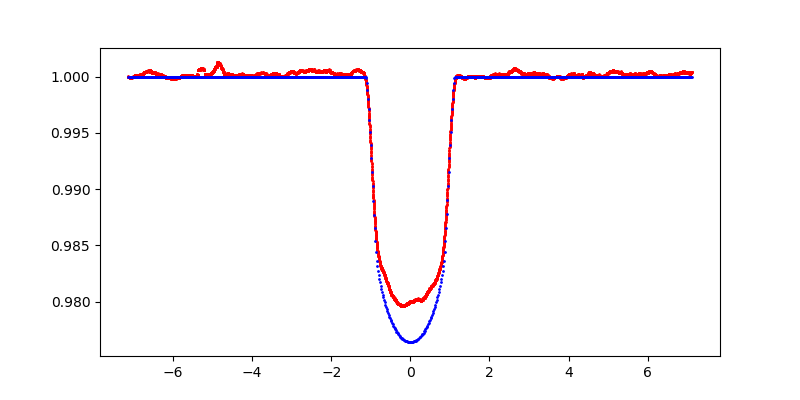

In [72]:
time_phased, smoothed_LC = transit_smooth(10, 1)

plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(time_phased, smoothed_LC, "r.", ms = 2)
ax.plot(ts_model, ls_model, "b.", ms = 2)

# Nelder-Mead (Amoeba)

In [7]:
lc_model = Model(eclipse_lc)
params = lc_model.make_params(u1_var = 0.5, u2_var = 0. ,per_var = 1.5, 
                              inc_var = 88., a_var = 5., rp_var = 0.15)

params['u1_var'].min = 0.
params['u1_var'].max = 1.
params['u2_var'].min = 0.
params['u2_var'].max = 1.
#params['inc_var'].min = 80.
params['inc_var'].max = 90.

In [8]:
t_p = time_phased
s_lc = smoothed_LC

start_time = timeit.default_timer()

result = lc_model.fit(s_lc, params, x = t_p, method = 'nelder')
print(result.fit_report())
#dely = result.eval_uncertainty(x = t_p, sigma = 3)

elapsed = timeit.default_timer() - start_time

logger.info(elapsed)

/home/sampa/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/sampa/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


[[Model]]
    Model(eclipse_lc)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 184
    # data points      = 8693
    # variables        = 6
    chi-square         = 8.3108e-04
    reduced chi-square = 9.5670e-08
    Akaike info crit   = -140493.430
    Bayesian info crit = -140451.008
##  Warning: uncertainties could not be estimated:
[[Variables]]
    u1_var:   0.49988989 +/- 2.8172e-04 (0.06%) (init = 0.5)
    u2_var:   4.4675e-04 +/-        nan (nan%) (init = 0)
    per_var:  1.46660077 +/- 1.2502e-04 (0.01%) (init = 1.5)
    a_var:    5.55268505 +/- 1.3046e-04 (0.00%) (init = 5)
    inc_var:  87.8598888 +/- 1.2875e-04 (0.00%) (init = 88)
    rp_var:   0.13077257 +/- 2.8491e-05 (0.02%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(per_var, inc_var) = -0.403
    C(per_var, a_var)   =  0.176
    C(a_var, rp_var)    =  0.165


<IPython.core.display.Javascript object>


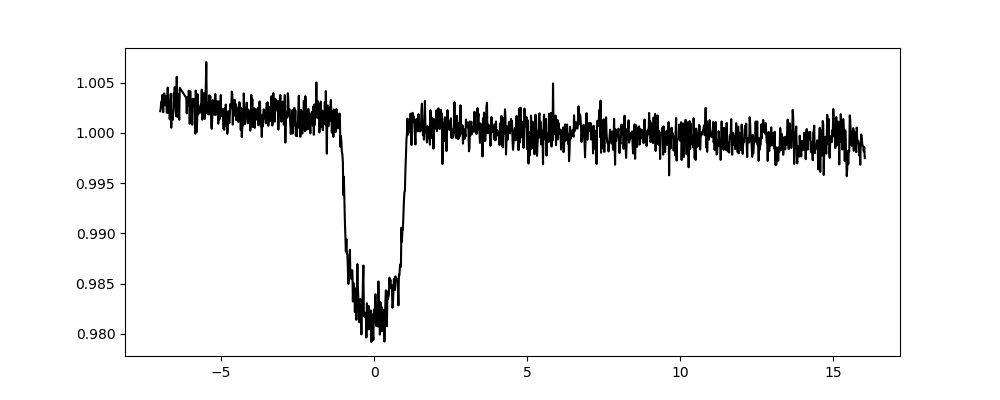

NameError: name 'result' is not defined

In [67]:
plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()

ax.plot(t_p, s_lc, 'k', label='data')
ax.plot(t_p, result.best_fit, 'r', label='fit')
plt.legend()
plt.show()

# MCMC

In [ ]:
u1_p0 = result.params['u1_var'].value
u2_p0 = result.params['u2_var'].value
per_p0 = result.params['per_var'].value
a_p0 = result.params['a_var'].value
inc_p0 = result.params['inc_var'].value
rp_p0 = result.params['rp_var'].value

In [ ]:
time = t_p
flux = s_lc

flux_err = numpy.var(flux)
data = (time, flux, flux_err)
nwalkers = 75
niter = 200
initial = numpy.array([u1_p0, u2_p0, per_p0, a_p0, inc_p0, rp_p0])
ndim = len(initial)
p0 = [numpy.array(initial) + 1e-4 * numpy.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
start_time = timeit.default_timer()

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

logger.info(elapsed)

In [ ]:
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

In [ ]:
theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
best_fit_model = eclipse_mcmc(time, theta_max)

plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()
plt.plot(time, flux, label = 'flux')
plt.plot(time, best_fit_model, label='Highest Likelihood Model')
plt.show()
print('Theta max: ',theta_max)

In [ ]:
labels = ['u1','u2','per','a','inc','rp']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [ ]:
med_model, spread = sample_walkers(100,samples)

In [ ]:
plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()

plt.plot(time, flux, label='flux')
plt.plot(time, best_fit_model, label='Highest Likelihood Model')
plt.fill_between(time, med_model-spread, med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.legend()

In [ ]:
for i in range(ndim):
    mcmc = numpy.percentile(samples[:, i], [16, 50, 84])
    q = numpy.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [53]:
t_p = tim[0]
s_lc = lcurve[0]

a1 = 5.179
inc1 = 87.69
per1 = 1.381
rp1 = 0.13

In [64]:
estrela_ = estrela(373, 240., 0.384, 0.287, len(t_p))
Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()
estrelaManchada = estrela_.getEstrela()
    
eclipse = Eclipse(Nx,Ny,raioEstrelaPixel,estrelaManchada)
eclipse.criarEclipse(per1, a1, inc1, rp1)
lc0 = numpy.array(eclipse.getCurvaLuz()) 
ts0 = numpy.array(eclipse.getTempoHoras()) 

bb = numpy.where((t_p >= min(ts0)) & (t_p <= max(ts0)))
bb = numpy.where((ts0 >= -5.) & (ts0 <= 5.))
dd = numpy.where((t_p >= -5.) & (t_p <= 5.))

<IPython.core.display.Javascript object>


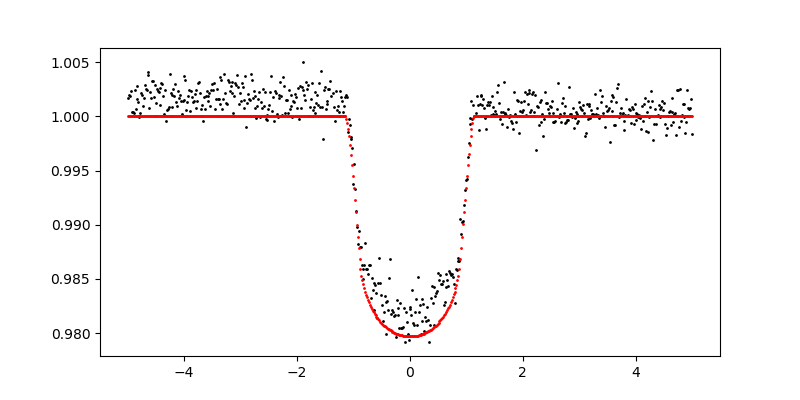

In [73]:
plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(t_p[dd], s_lc[dd], "k.", ms = 2)
#ax.plot(t_p, s_lc, "k.", ms = 2)
ax.plot(ts0[bb], lc0[bb], "r.", ms = 2)

<IPython.core.display.Javascript object>


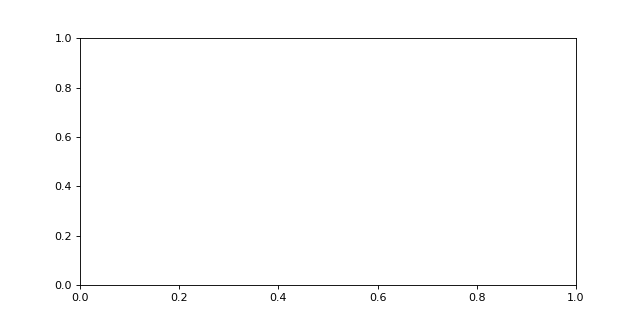

ValueError: operands could not be broadcast together with shapes (612,) (600,) 

In [66]:
plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(ts0[bb], s_lc[dd] - lc0[bb], "k.", ms = 2)

In [14]:
dtor = numpy.pi/180.

a1 = 5.179
inc1 = 87.69
per1 = 1.381
rp1 = 0.13

fa = [0.1, 0.05, 0.2, 0.1]
fi = [0.7, 0.5, 0.9, 0.7]
lg = [-30., 0., 30., 45.]

lat = - numpy.arcsin(a1*numpy.cos(inc1*dtor))/dtor

estrela_ = estrela(373, 240., 0.384, 0.287, 856)

estrela = estrela_.manchas(fa[0], fi[0], lat, lg[0])
estrela = estrela_.manchas(fa[1], fi[1], lat, lg[1])
estrela = estrela_.manchas(fa[2], fi[2], lat, lg[2])
estrela = estrela_.manchas(fa[3], fi[3], lat, lg[3])

Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()
estrelaManchada = estrela_.getEstrela()

eclipse = Eclipse(Nx, Ny, raioEstrelaPixel, estrelaManchada)

eclipse.criarEclipse(per1, a1, inc1, rp1)
lc_model = numpy.array(eclipse.getCurvaLuz())
ts_model = numpy.array(eclipse.getTempoHoras())


/home/sampa/Dropbox/Python_Scripts/estrela_nv1.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  anguloRot=np.abs(np.arctan(ys/xs))    # em radianos


<IPython.core.display.Javascript object>


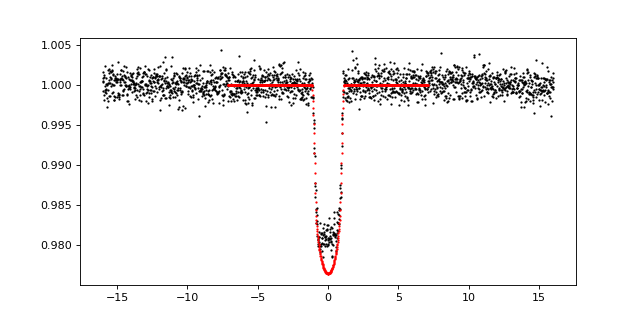

In [15]:
plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(tim[1], lcurve[1], "k.", ms = 2)
ax.plot(ts_model, ls_model, "r.", ms = 2)


In [ ]:
plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()


#ax.plot(ts_model, ls_model, "k.", ms = 2)
ax.plot(tim[1], lcurve[1] - ls_model, "k.", ms = 2)